In [1]:
pip install keras tensorflow scikit-learn numpy


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, accuracy_score

# Load ARP MITM data and labels
arp_mitm_data = pd.read_csv('ARP_MitM_dataset.csv')
arp_mitm_labels = pd.read_csv('ARP_MitM_labels.csv')

# Use the union of features for training and evaluation
selected_features = [12, 77, 108, 111, 54, 58, 27, 61, 62, 63]
arp_mitm_data = arp_mitm_data.iloc[:, selected_features]

# Add labels to the dataset
arp_mitm_data['Label'] = arp_mitm_labels['x'] # Adjust if the column name is different

# Split the full data into training and testing sets
X_full = arp_mitm_data.drop(columns=['Label'])
y_full = arp_mitm_data['Label']
X_train_full, X_test, y_train_full, y_test = train_test_split(X_full, y_full, test_size=0.2, shuffle=True)

# Filter the training set for benign cases (label = 0)
X_train = X_train_full[y_train_full == 0]
y_train = y_train_full[y_train_full == 0]

# Now proceed with your model training using X_train and y_train
# and model evaluation using X_test and y_test



In [3]:
# In[5]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping

def create_autoencoder(input_dim):
    # Define the sizes of the encoded representations
    encoding_dim_1 = int(input_dim / 2)
    encoding_dim_2 = int(encoding_dim_1 / 2)
    bottleneck_dim = int(encoding_dim_2 / 2)

    # Define input layer
    input_layer = Input(shape=(input_dim,))

    # Define encoding layers
    encoded_1 = Dense(encoding_dim_1, activation='relu')(input_layer)
    encoded_1 = Dropout(0.3)(encoded_1)  # Dropout layer
    encoded_2 = Dense(encoding_dim_2, activation='relu')(encoded_1)
    encoded_2 = Dropout(0.3)(encoded_2)  # Dropout layer
    bottleneck = Dense(bottleneck_dim, activation='relu')(encoded_2)

    # Define decoding layers
    decoded_1 = Dense(encoding_dim_2, activation='relu')(bottleneck)
    decoded_1 = Dropout(0.3)(decoded_1)  # Dropout layer
    decoded_2 = Dense(encoding_dim_1, activation='relu')(decoded_1)
    decoded_2 = Dropout(0.3)(decoded_2)  # Dropout layer
    output_layer = Dense(input_dim, activation='sigmoid')(decoded_2)

    # Combine the layers to create the autoencoder model
    autoencoder = Model(input_layer, output_layer)

    return autoencoder

In [4]:
# In[6]:
# 1. Feature Scaling:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Model Creation and Compilation:
input_dim = X_train_scaled.shape[1]
autoencoder = create_autoencoder(input_dim)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 3. Early Stopping:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 4. Training the Model:
autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_scaled, X_test_scaled),
                callbacks=[early_stopping])


2023-11-30 00:37:32.335062: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-30 00:37:32.335083: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-30 00:37:32.335088: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-30 00:37:32.335116: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-30 00:37:32.335132: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2023-11-30 00:37:32.841633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-30 00:37:32.881977: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


4250/4250 [==============================] - 36s 8ms/step - loss: 0.8914 - val_loss: 0.9135
Epoch 2/50
4250/4250 [==============================] - 35s 8ms/step - loss: 0.8297 - val_loss: 0.7995
Epoch 3/50
4250/4250 [==============================] - 35s 8ms/step - loss: 0.8061 - val_loss: 0.8805
Epoch 4/50
4250/4250 [==============================] - 35s 8ms/step - loss: 0.7937 - val_loss: 0.7969
Epoch 5/50
4250/4250 [==============================] - 35s 8ms/step - loss: 0.7974 - val_loss: 0.8882
Epoch 6/50
4250/4250 [==============================] - 35s 8ms/step - loss: 0.7941 - val_loss: 0.7958
Epoch 7/50
4250/4250 [==============================] - 35s 8ms/step - loss: 0.7938 - val_loss: 0.7960
Epoch 8/50
4250/4250 [==============================] - 35s 8ms/step - loss: 0.8064 - val_loss: 0.7820
Epoch 9/50
4250/4250 [==============================] - 35s 8ms/step - loss: 0.7961 - val_loss: 0.7966
Epoch 10/50
4250/4250 [==============================] - 36s 8ms/step - loss: 0.8117

In [5]:
# In[7]:
import numpy as np

# Predict the test set
predictions = autoencoder.predict(X_test_scaled)

import time

# Start timing before making predictions
start_time = time.time()

# Predict the reconstruction of the test set
reconstructed_test = autoencoder.predict(X_test_scaled)

# End timing after predictions are made
end_time = time.time()

# Calculate the elapsed time
prediction_time = end_time - start_time
print(f"Prediction time for test set: {prediction_time:.4f} seconds")


# Calculate mean squared error between predictions and actual values
mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)

15652/15652 [==============================] - 21s 1ms/step
Prediction time for test set: 23.1272 seconds


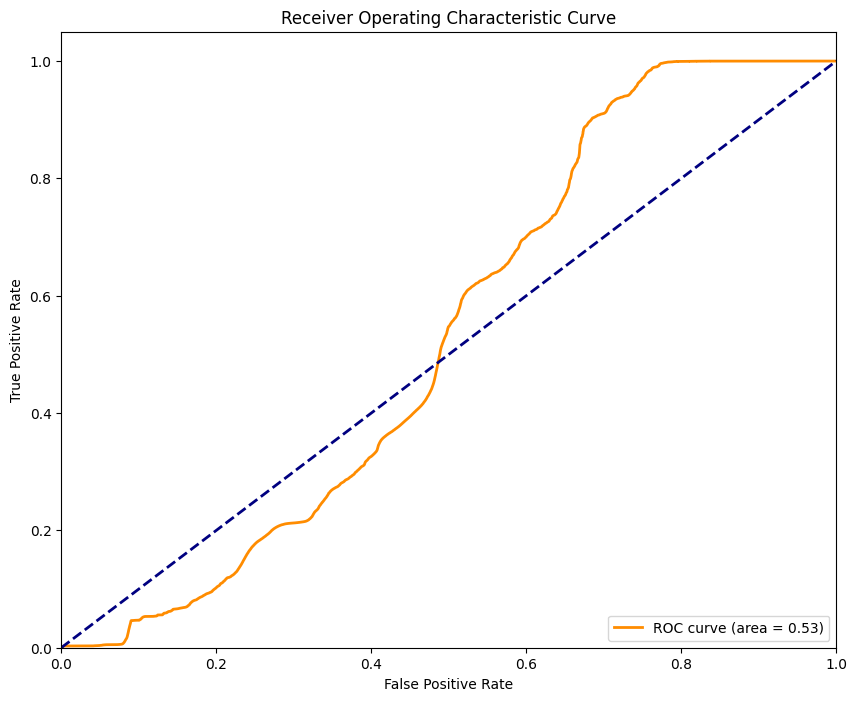

In [6]:
# In[8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, mse, pos_label= 1)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [7]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Ensure you use the scaled test data for making predictions
X_test_predictions = autoencoder.predict(X_test_scaled)

# Calculating the mean squared error (reconstruction error) between the original scaled data and their reconstructions
mse = np.mean(np.power(X_test_scaled - X_test_predictions, 2), axis=1)

# Print the mean squared errors
print("Reconstruction error (MSE) for each sample:")
print(mse)
general_mse = np.mean(mse)

# Choose a threshold value for which F1 score is maximized
thresholds = np.linspace(0.1, 10, 200)  # Adjust the range and granularity as needed

# Convert 'y_test' labels to binary format (0 for 'BENIGN' and 1 for 'Anomaly')
y_test_binary = (y_test == 'DoS Hulk').astype(int)

f1_scores = [f1_score(y_test_binary, mse > threshold) for threshold in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Predicting anomalies using the optimal threshold
y_pred = (mse > optimal_threshold).astype(int)

# Calculating F1 score and accuracy based on the reconstruction error
f1 = f1_score(y_test_binary, y_pred)
accuracy = accuracy_score(y_test_binary, y_pred)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"General MSE: {general_mse}")


15652/15652 [==============================] - 21s 1ms/step
Reconstruction error (MSE) for each sample:
[0.27456705 0.52689138 0.5255255  ... 0.17363903 0.08282737 0.40265684]
Optimal Threshold: 0.1
F1 Score: 0.0
Accuracy: 0.12118301940285992
General MSE: 0.7820370272886925


In [8]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import shap
# Create a SHAP explainer object - using a KernelExplainer for a generic model
explainer = shap.KernelExplainer(autoencoder.predict, X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# Plotting the SHAP values
shap.summary_plot(shap_values, X_test)

33993/33993 [==============================] - 47s 1ms/step


Using 1087760 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/500854 [00:00<?, ?it/s]

1/1 [==============================] - 0s 111ms/step
